### Cell 0: ( Only for Colab ) Install the git **repository**

In [ ]:
import sys
import os

# 1. Clone the repository
!git clone -b trajectory_tracking_policy https://github.com/orc-podavini-grisenti/final_assignment

# 2. Point the project_root specifically to the cloned folder
# In Colab, the folder structure will be /content/final_assignment/
project_root = os.path.abspath('/content/final_assignment')

# 3. Add that specific folder to the system path
if project_root not in sys.path:
    sys.path.append(project_root)


# 4. Link the Drive to the colab in order to store the results
from google.colab import drive
drive.mount('/content/drive')

drive_path = "/content/drive/MyDrive/final_assignment/outputs/models_saved"

# Crea la cartella se non esiste
if not os.path.exists(drive_path):
    os.makedirs(drive_path)

fatal: destination path 'final_assignment' already exists and is not an empty directory.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Cell 1: Imports & Setup

In [15]:
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
import numpy as np
import matplotlib.pyplot as plt

# --- PATH SETUP ---
# Add the project root to sys.path so we can import envs/planner
# Adjust '..' depending on where this notebook is located relative to root
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

from envs.unicycle_env import UnicycleEnv
from planner.dubins_planner import DubinsPlanner
from models.trajectory_tracking_network import TTNetwork
from utils.normalization import ObservationNormalizer
from utils.reward import TrajectoryTrackingReward

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")

Running on: cuda


### Cell 2: Load Training Hyperparameters

In [23]:
# Hyperparameters
MAX_EPISODES = 2000
MAX_STEPS    = 200
LR           = 3e-4
BATCH_SIZE   = 20
GAMMA        = 0.99

SAVE_ON_DRIVE = False

### Cell 3: Intialization

In [17]:
# Init Enviroment and Dubins Planner
env = UnicycleEnv()

# Initilize the Network.
obs_dim = 3     # Obs dim is 3 (rho, alpha, d_theta)
action_dim = 2  # v, omega

policy = TTNetwork(obs_dim, action_dim).to(device)

# Initializa the otpimizar
optimizer = optim.Adam(policy.parameters(), lr=LR)

# --- NEW: Scheduler ---
# Reduces LR by factor of 0.5 every 200 episodes
# This helps the network "settle" into the precise solution
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.5)

# Initializa the input normalizer
obs_normalizer = ObservationNormalizer(max_dist=3.0)

# Initilize the reward calculator
reward_calculator = TrajectoryTrackingReward()

gamma = GAMMA

# Memory buffer for the current episode
log_probs = []
rewards = []

# Memory buffer fot the current batch
loss_history = [] # Store all the batch losses

### Cell 4: Helpers

In [18]:
def get_tracking_obs(target_waypoint, robot_state):
    # 1. Compute errors relative to this specific waypoint   
    dx = target_waypoint[0] - robot_state[0]
    dy = target_waypoint[1] - robot_state[1]
    
    # Rho: Distance to the target waypoint
    rho = np.sqrt(dx**2 + dy**2)
    
    # Alpha: Angle to the target waypoint (relative to robot heading)
    theta = env.state[2]
    alpha = np.arctan2(dy, dx) - theta
    # Normalize alpha to [-pi, pi]
    alpha = (alpha + np.pi) % (2 * np.pi) - np.pi
    
    # D_theta: Orientation error (target heading - robot heading)
    target_heading = target_waypoint[2]
    d_theta = target_heading - theta
    # Normalize d_theta to [-pi, pi]
    d_theta = (d_theta + np.pi) % (2 * np.pi) - np.pi

    # 3. Create the new tracking observation
    # This replaces: tracking_obs = obs[:3]
    tracking_obs = np.array([rho, alpha, d_theta], dtype=np.float32)
    return tracking_obs


def get_action(obs):
    """Samples an action and stores its log_probability."""
    # Use the imported normalizer to normaliza the inputs features to give the same relevance
    norm_obs = obs_normalizer.normalize_tt(obs)

    obs_t = torch.FloatTensor(norm_obs).unsqueeze(0).to(device)

    # Call the network to get a action distribution
    mean, std = policy(obs_t)
    dist = Normal(mean, std)

    # Sample a randome action from this distribution
    # NB: randomcicity ensure exploration
    action = dist.sample()

    # Store log_prob for the update step later
    # Sum over action dimensions (v and omega)
    log_prob = dist.log_prob(action).sum(dim=1)
    log_probs.append(log_prob)

    # Return numpy action for the environment
    # Clip to ensure physical validity [-1, 1]
    return np.clip(action.cpu().detach().numpy()[0], -1.0, 1.0)


def store_reward(reward):
    rewards.append(reward)

def store_batch_loss(loss):
    loss_history.append(loss)

def sample_radius(mean=1.65, std=0.3, min_r=1, max_r=2.5, size=1):
    """
    Samples a radius using a Gaussian distribution, strictly constrained.
    """
    # 1. Sample from the normal distribution
    samples = np.random.normal(loc=mean, scale=std, size=size)

    # 2. Hard constrain using clipping
    constrained_samples = np.clip(samples, min_r, max_r)

    return constrained_samples[0] if size == 1 else constrained_samples

### Cell 5: Reinforce Update

In [19]:
# Global storage for the whole batch of trajectories
batch_log_probs = []        # store the actions log probabilities of an entire batch [ used during the update ]
batch_returns = []          # store the Retunr To Go of an entire batch [ used during the update ]

def calculate_discounted_returns():
    """
    Calculates the 'Return-to-Go' (G_t) for the current episode using causality.

    Mathematical Concept:
    Instead of using the total reward C(tau) for every step, we use G_t:
    G_t = sum_{k=t}^H gamma^(k-t) * r_k

    This reduces variance because actions at time 't' are only reinforced
    based on rewards that happen *after* time 't' (Causality).
    """
    global log_probs, rewards, batch_log_probs, batch_returns

    G_t = 0
    returns = []

    # 1. Calculate Discounted Returns (Backwards)
    # We iterate backwards to easily compute G_t = r_t + gamma * G_{t+1}
    for r in reversed(rewards):
        G_t = r + gamma * G_t
        returns.insert(0, G_t)

    # 2. Store for the Batch Update
    # We do NOT normalize here. We wait to collect all episodes in the batch
    # so we can normalize across the entire dataset (Batch-wise normalization).
    batch_log_probs.extend(log_probs)
    batch_returns.extend(returns)

    # Clear episode memory
    log_probs = []
    rewards = []

def update():
    """
    Performs the Policy Gradient Update using the REINFORCE algorithm.

    Equation Implemented:
    ∇J ≈ (1/N) * Σ_i Σ_t [ ∇ log π(u_t|x_t) * G_t ]

    Where:
    - (1/N): Averaging over the batch size (len(batch_returns))
    - Σ_t: Summing over time steps (done via torch.sum or iterative addition)
    - ∇ log π: Gradients calculated via loss.backward() on log_probs
    - G_t: The normalized returns-to-go
    """
    global batch_log_probs, batch_returns, optimizer

    # Security check: if batch is empty, skip
    if len(batch_returns) == 0:
        return

    # 1. Prepare Data
    # Convert list of returns to a Tensor
    returns_t = torch.tensor(batch_returns).float().to(device)

    # 2. Batch-Wise Normalization (Crucial for Stability)
    # This aligns the returns to be roughly N(0, 1), stabilizing the gradients.
    # It acts as a baseline: actions with G_t > mean are encouraged (+),
    # actions with G_t < mean are discouraged (-).
    if len(returns_t) > 1:
        returns_t = (returns_t - returns_t.mean()) / (returns_t.std() + 1e-9)

    # 3. Calculate Policy Loss
    # We want to maximize J, so we minimize Loss = -J
    # Loss = - Σ ( log_prob * G_t )
    policy_loss = []
    for log_prob, G_t in zip(batch_log_probs, returns_t):
        # Term: - log π(u_t|x_t) * G_t
        policy_loss.append(-log_prob * G_t)

    # Summing all terms corresponds to the Σ_i Σ_t part of the equation
    loss = torch.stack(policy_loss).sum()

    # 4. Backpropagation
    # Dividing by the number of episodes corresponds to the (1/N) term
    # This keeps the gradient magnitude consistent regardless of batch size.
    loss = loss / BATCH_SIZE

    optimizer.zero_grad()
    loss.backward()  # This computes ∇_theta

    # Gradient Clipping (Optional but recommended to prevent exploding gradients)
    torch.nn.utils.clip_grad_norm_(policy.parameters(), 1.0)

    optimizer.step() # Update parameters theta

    # 5. Logging and Cleanup
    store_batch_loss(loss.item())

    # Clear batch memory for the next set of episodes
    batch_log_probs = []
    batch_returns = []

### Cell 6: Training

In [21]:
reward_history = [] # Store the reward for each episode ( used for final plotting )

print("Starting Training...")

# Run all the episodes
for episode in range(MAX_EPISODES):
    # Each episode is a different enviroment configuration
    obs, info = env.reset()

    start_pose = env.state
    goal_pose = env.goal

    # We change also the minimum radius of the dubins curve
    random_radius = sample_radius()
    planner = DubinsPlanner(curvature=random_radius, step_size=0.2)
    path = planner.get_path(start_pose, goal_pose)
    if path is None: continue

    path_idx = 0
    ep_reward = 0
    episode_errors = []
    breack_reason = "Max step reached"

    for t in range(MAX_STEPS):
        old_idx = path_idx

        # --- 1. Forward: The network choose the action ---
        target_waypoint = path[path_idx]        # The goal is to reach the next waypoint of the path
        # Input of the network is the Ego-Centric Observation Vector: 
        #   1. rho (ρ): [0, inf]        Euclidean distance to the goal.        
        #   2. alpha (α): [-pi, pi]     The angle of the goal *relative* to the robot's current heading.
        #   3. d_theta (δθ): [-pi, pi]  The difference between the desired goal orientation and current heading.
        tracking_obs = get_tracking_obs(target_waypoint, env.state[:2])       
        action = get_action(tracking_obs)

        # --- 2. Environment Step ---
        obs, terminated, truncated, info = env.step(action)


        # --- 3. Update Path Tracking Logic ---
        # ( understand which waypoint of the track the robot is near)
        # 1) extract all the path waypoints (x,y) coordinates
        path_xy = path[:, :2]           
        # 2) compute the distance between the current robot position and all the waypoints                            
        dists = np.linalg.norm(path_xy - env.state[:2], axis=1)     
        # 3) take the minimum distance, this is consider as the 'tracking error'
        current_tracking_error = np.min(dists)             # current_tracking_error = 'distance to the closest waypoint'    
        episode_errors.append(current_tracking_error)

        # 4) Derive the waypoint id closest to the robot, it tell us the robot position respect to the path
        closest_idx = np.argmin(dists)
        # 5) Now the goal of the robot is to reach the next waypoint 
        lookahead_idx = closest_idx + 1
        # This check is used to menage strang behavior as the robot by moving randomly go revers to the path
        if lookahead_idx > path_idx and lookahead_idx < len(path):
            path_idx = lookahead_idx


        # 3. --- Calculate Step Reward ---
        # Calculate checkpoints cleared
        checkpoints_cleared = max(0, path_idx - old_idx)
        terminal_reason = None 
        if info['is_success']:
            terminated = True
            terminal_reason = "goal"
            breack_reason = "Goal Reached"
        elif info['collision']:
            terminated = True
            terminal_reason = "collision"
            breack_reason = "Collision"
        elif current_tracking_error > 2.0:
            terminated = True
            terminal_reason = "off_path"
            breack_reason = "Off the Path"
        elif t >= MAX_STEPS - 1:
            truncated = True
            terminal_reason = "timeout"
        
        # 4. Compute the Reward
        # Pass the tracking observation (rho, alpha, d_theta), action, and status
        step_reward = reward_calculator.compute_reward(
            tracking_obs=tracking_obs,
            action=action,
            checkpoints_cleared=checkpoints_cleared,
            terminal_reason=terminal_reason
        )

        # 5. Store and Accumulate
        store_reward(step_reward)
        ep_reward += step_reward

        # 6. Brake the episod if it is terminated or truncated
        if terminated or truncated:
            break

    # Update logic (discounting, logging, etc.)
    calculate_discounted_returns()
    avg_error = np.mean(episode_errors)
    # ... rest of your update/log code ...

    # 4. If we have collected 'm' trajectories, perform the update
    if (episode + 1) % BATCH_SIZE == 0:
        update() 
        print(f"Update performed at episode {episode}")

    reward_history.append(ep_reward)

    if (episode + 1) % BATCH_SIZE == 0:
        avg_r = np.mean(reward_history[-20:])
        print(f"Episode {episode} | Avg Reward: {avg_r:.1f} | Avg Error: {avg_error:.4f}m | Path Len: {len(path)}, Path Step Reached: {path_idx}, {breack_reason}")

print("Training Complete.")

Starting Training...
Update performed at episode 19
Episode 19 | Avg Reward: 93.8 | Avg Error: 0.5483m | Path Len: 25, Path Step Reached: 19, Max step reached
Update performed at episode 39
Episode 39 | Avg Reward: 78.1 | Avg Error: 0.7351m | Path Len: 20, Path Step Reached: 10, Max step reached
Update performed at episode 59
Episode 59 | Avg Reward: 57.2 | Avg Error: 0.6345m | Path Len: 17, Path Step Reached: 16, Max step reached
Update performed at episode 79
Episode 79 | Avg Reward: 109.4 | Avg Error: 0.5508m | Path Len: 22, Path Step Reached: 21, Max step reached
Update performed at episode 99
Episode 99 | Avg Reward: 82.9 | Avg Error: 0.6813m | Path Len: 20, Path Step Reached: 19, Max step reached
Update performed at episode 119
Episode 119 | Avg Reward: 25.1 | Avg Error: 1.0174m | Path Len: 8, Path Step Reached: 5, Max step reached
Update performed at episode 139
Episode 139 | Avg Reward: 71.3 | Avg Error: 0.7746m | Path Len: 33, Path Step Reached: 32, Max step reached
Update per

### Cell 7: Visualization & Save
Plot the learning curve to verify convergence.

Results will be saved to: experiments/run_20260105_151445


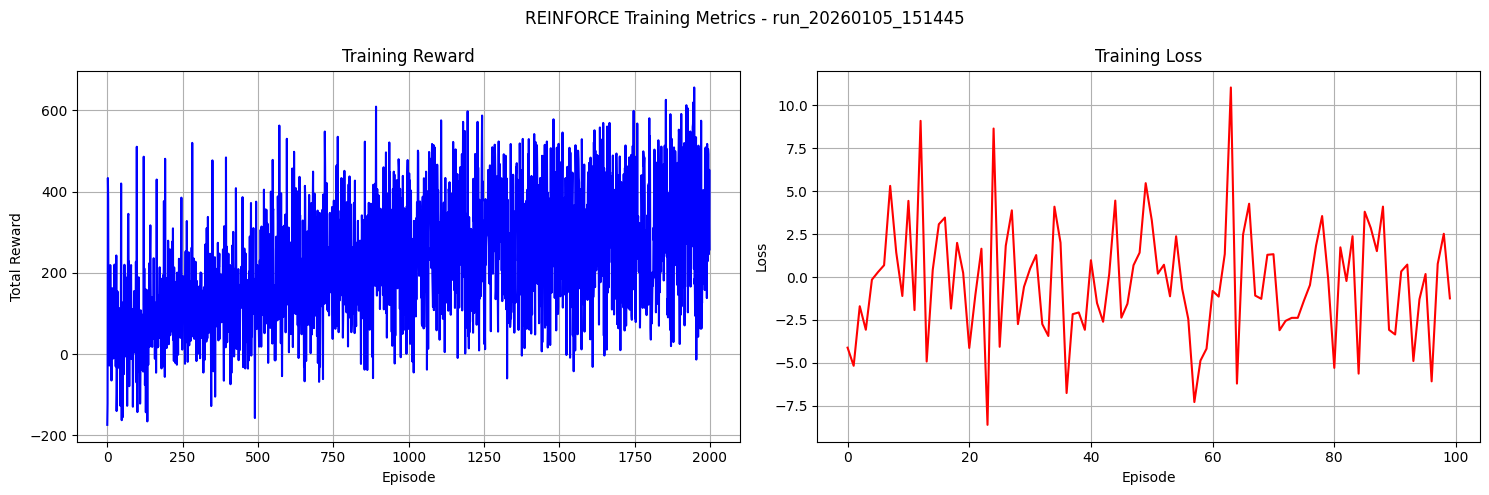

------------------------------
Execution complete.
Directory: experiments/run_20260105_151445
Saved: policy_model.pth, training_metrics_plot.png, histories (.npy)
------------------------------


In [24]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# --- 1. SETUP DIRECTORY STRUCTURE ---
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
run_id = f"run_{current_time}"

if SAVE_ON_DRIVE:
    base_output_path = os.path.join(drive_path, "experiments")
else:
    base_output_path = "experiments"

output_dir = os.path.join(base_output_path, run_id)
os.makedirs(output_dir, exist_ok=True)

print(f"Results will be saved to: {output_dir}")

# --- 2. PLOTTING AND SAVING FIGURES ---
# We create a figure with 2 subplots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Process histories to ensure they are plottable (handle tensors)
clean_rewards = [r.detach().cpu().item() if torch.is_tensor(r) else r for r in reward_history]
clean_losses = [l.detach().cpu().item() if torch.is_tensor(l) else l for l in loss_history]

# Plot 1: Total Reward
ax1.plot(clean_rewards, color='blue')
ax1.set_title("Training Reward")
ax1.set_xlabel("Episode")
ax1.set_ylabel("Total Reward")
ax1.grid(True)

# Plot 2: Training Loss
# Note: Ensure you are appending your loss values to a list named 'loss_history' during training
ax2.plot(clean_losses, color='red')
ax2.set_title("Training Loss")
ax2.set_xlabel("Episode")
ax2.set_ylabel("Loss")
ax2.grid(True)

plt.suptitle(f"REINFORCE Training Metrics - {run_id}")
plt.tight_layout() # Adjust spacing so titles don't overlap

# Save the combined plot
plot_filename = "training_metrics_plot.png"
plt.savefig(os.path.join(output_dir, plot_filename))
plt.show()

# --- 3. SAVING MODEL AND DATA ---
model_filename = "policy_model.pth"
torch.save(policy.state_dict(), os.path.join(output_dir, model_filename))

# Save both histories for future analysis
np.save(os.path.join(output_dir, "reward_history.npy"), np.array(clean_rewards))
np.save(os.path.join(output_dir, "loss_history.npy"), np.array(clean_losses))

print("-" * 30)
print(f"Execution complete.")
print(f"Directory: {output_dir}")
print(f"Saved: {model_filename}, {plot_filename}, histories (.npy)")
print("-" * 30)

### Cell 8: ⚠ Delete the train directory ( only for bed results )

In [ ]:
import shutil

# --- DELETE CURRENT EXPERIMENT DIRECTORY ---
# Ask for confirmation to prevent accidental deletion
confirm = input(f"Do you want to delete the directory '{run_id}'? (y/n): ")

if confirm.lower() == 'y':
    try:
        # shutil.rmtree deletes a directory and all its contents
        shutil.rmtree(output_dir)
        print(f"Successfully deleted: {output_dir}")
    except OSError as e:
        print(f"Error: {e.strerror}. Could not delete the directory.")
else:
    print("Deletion cancelled. Experiment results preserved.")